# Activo la libreria de drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Verificacion tecnica del sistema.



In [2]:
from platform import python_version
import tensorflow as tf

print("Version de python: " + python_version())
print("Version de tensorflow: " + tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

Version de python: 3.7.10
Version de tensorflow: 2.5.0
Wed Jun  2 02:36:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Importamos librerias.

In [3]:
# import the libraries as shown below
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras.backend as K

In [4]:
# re-size all the images to this

train_path = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/train/rgb'
valid_path = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/test/rgb'

In [21]:
K.clear_session()

def build_model(num_classes, img_size=512):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.NASNetLarge(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    # model.trainable = True
    for layer in model.layers[:-1]:
      layer.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="NASNetLarge")
    # model.summary()
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

In [6]:
# useful for getting number of output classes
folders = glob(train_path + '/*')
num_imagenes = glob(train_path + '/*/*')

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
batch_size_ = 32

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (512, 512),
                                                 batch_size = batch_size_,
                                                 class_mode = 'categorical')

Found 1080 images belonging to 9 classes.


In [9]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (512, 512),
                                            batch_size = batch_size_,
                                            class_mode = 'categorical')

Found 450 images belonging to 9 classes.


In [10]:
num_classes = len(folders)
num_images = len(num_imagenes)

model = build_model(num_classes)

In [11]:
import time
import math

def entrenamiento_gpu_flow_from_directory():
  with tf.device('/device:GPU:0'):
    history = model.fit(
        training_set,
        validation_data=test_set,
        epochs=50,
        steps_per_epoch=math.ceil(num_images/batch_size_))
  return history

inicio = time.time()
history = entrenamiento_gpu_flow_from_directory()
fin = time.time()

Epoch 1/10
34/34 [==============================] - 91s 2s/step - loss: 1.5712 - categorical_accuracy: 0.5065 - val_loss: 1.7569 - val_categorical_accuracy: 0.5000
Epoch 2/10
34/34 [==============================] - 71s 2s/step - loss: 0.8274 - categorical_accuracy: 0.7074 - val_loss: 1.6318 - val_categorical_accuracy: 0.5222
Epoch 3/10
34/34 [==============================] - 71s 2s/step - loss: 0.6097 - categorical_accuracy: 0.7778 - val_loss: 1.5778 - val_categorical_accuracy: 0.5333
Epoch 4/10
34/34 [==============================] - 70s 2s/step - loss: 0.5247 - categorical_accuracy: 0.8185 - val_loss: 1.4983 - val_categorical_accuracy: 0.5511
Epoch 5/10
34/34 [==============================] - 69s 2s/step - loss: 0.5009 - categorical_accuracy: 0.8333 - val_loss: 1.4275 - val_categorical_accuracy: 0.5556
Epoch 6/10
34/34 [==============================] - 70s 2s/step - loss: 0.4174 - categorical_accuracy: 0.8556 - val_loss: 1.3607 - val_categorical_accuracy: 0.5600
Epoch 7/10
34/34

In [20]:
print("Tiempo de entrenamiento gpu flow_from_directory " + str((fin-inicio)/60) + " minutos")

Tiempo de entrenamiento gpu flow_from_directory 11.998117184638977 minutos


In [16]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Costo', fontsize=24)
        plt.plot(xc,yc,'-r',label='Costo entrenamiento')
    if typeData=="categorical_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['categorical_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy entrenamiento')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Costo', fontsize=24)
        plt.plot(xc,yc,'--b',label='Validación costo')
    if typeData=="val_categorical_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_categorical_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Validación accuracy')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Numero de epocas',fontsize=24)
    plt.grid(True)

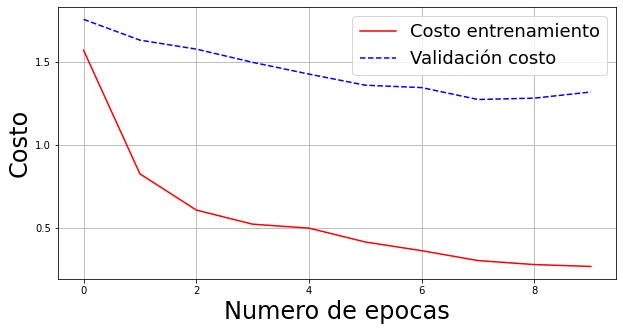

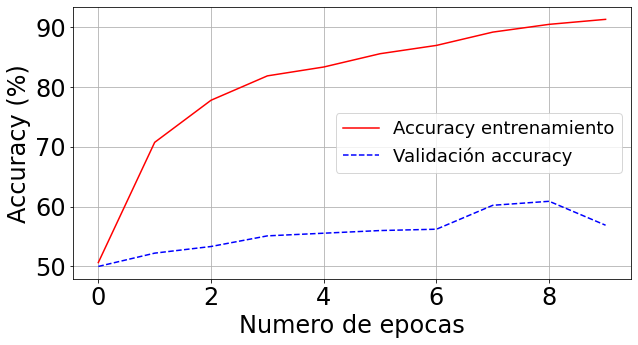

In [18]:
epochs = 10
plotTraining(history,epochs,"loss")
plotTraining(history,epochs,"categorical_accuracy")
plotTraining(history,epochs,"val_loss")
plotTraining(history,epochs,"val_categorical_accuracy")

In [19]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/notebooks/mineria/Model/nasnet_10epo_from_directory.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
import time
import math

def entrenamiento_gpu_flow_from_directory():
  with tf.device('/device:GPU:0'):
    history = model.fit(
        training_set,
        validation_data=test_set,
        epochs=50,
        steps_per_epoch=math.ceil(num_images/batch_size_))
  return history

inicio = time.time()
history = entrenamiento_gpu_flow_from_directory()
fin = time.time()

Epoch 1/50
34/34 [==============================] - 69s 2s/step - loss: 0.2210 - categorical_accuracy: 0.9306 - val_loss: 1.3423 - val_categorical_accuracy: 0.6000
Epoch 2/50
34/34 [==============================] - 69s 2s/step - loss: 0.2000 - categorical_accuracy: 0.9361 - val_loss: 1.3867 - val_categorical_accuracy: 0.6022
Epoch 3/50
34/34 [==============================] - 68s 2s/step - loss: 0.2016 - categorical_accuracy: 0.9352 - val_loss: 1.5552 - val_categorical_accuracy: 0.5778
Epoch 4/50
34/34 [==============================] - 69s 2s/step - loss: 0.2253 - categorical_accuracy: 0.9278 - val_loss: 1.6095 - val_categorical_accuracy: 0.5844
Epoch 5/50
34/34 [==============================] - 68s 2s/step - loss: 0.2012 - categorical_accuracy: 0.9389 - val_loss: 1.6673 - val_categorical_accuracy: 0.5756
Epoch 6/50
34/34 [==============================] - 68s 2s/step - loss: 0.1756 - categorical_accuracy: 0.9380 - val_loss: 1.7060 - val_categorical_accuracy: 0.5733
Epoch 7/50
34/34

In [23]:
print("Tiempo de entrenamiento gpu flow_from_directory " + str((fin-inicio)/60) + " minutos")

Tiempo de entrenamiento gpu flow_from_directory 57.29518755276998 minutos


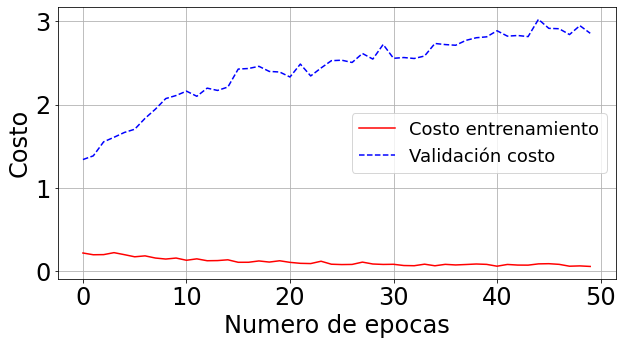

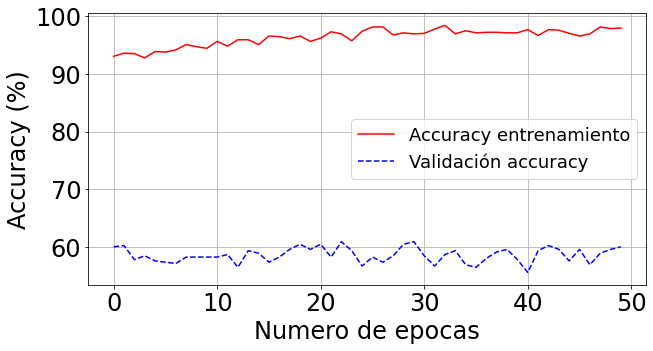

In [24]:
epochs = 50
plotTraining(history,epochs,"loss")
plotTraining(history,epochs,"categorical_accuracy")
plotTraining(history,epochs,"val_loss")
plotTraining(history,epochs,"val_categorical_accuracy")

In [25]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/notebooks/mineria/Model/nasnet_50epo_from_directory.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
